We now move into part 3 of the tutorial. By this point, you should have generated a perfect alanine dataset and reconstructed its site-specific isotopic structure. Here, we will provide a set of guidelines as to how to define and execute a new experiment. This will involve feedback between theory and experiment--to observe which fragments are observed, which peaks can be extracted, and what information those can define. We will again use alanine as an example. 

In [2]:
import sys; sys.path.insert(0, '..')

from datetime import date

today = date.today()

import copy
import json

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import basicDeltaOperations as op
import calcIsotopologues as ci
import fragmentAndSimulate as fas
import solveSystem as ss
import alanineTest
import spectrumVis
import readInput as ri

We recommend that the user define a .py file like "alanineTest", allowing one to easily generate new synthetic datasets. This will be invaluable. Discovering the fragmentation subgeometries will require some experimental data; in turn, the theoretical dataset can be used to predict the spectrum. We here use synthetic measurements to do so:

In [2]:
deltas = [-30,-30,0,0,0,0]
fragSubset = ['full','44']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltas, fragSubset)

unresolvedDict = {}
calcFF = False
forbiddenPeaks = {}
UValueList = []
MNMassThreshold = 1
molecularAvgMassThreshold = 2

byAtom = ci.inputToAtomDict(df, disable = True)

predictedMeasurement, MNDict, fractionationFactorsSmp = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   outputPath = None,
                                                               calcFF = calcFF,
                                                               ffstd = 0.05,
                                                   unresolvedDict = unresolvedDict,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   MNMassThreshold = MNMassThreshold,
                                                   molecularAvgMassThreshold = molecularAvgMassThreshold)

  0%|                                                                                         | 0/1512 [00:00<?, ?it/s]

Delta 18O
0.0
Calculating Isotopologue Concentrations
Compiling Isotopologue Dictionary
Calculating Isotopologue Concentrations


100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 23688.31it/s]

Compiling Isotopologue Dictionary
Simulating Measurement


We may visualize the spectrum using some functions to help assign and identify experimentally observed peaks. We first do this for the full molecule.

100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 20645.39it/s]


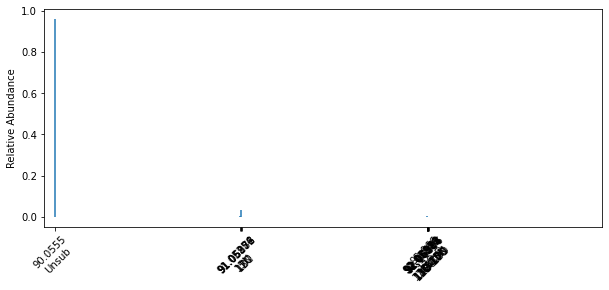

In [3]:
spectrumVis.fullSpectrumVis(df, byAtom, figsize = (10,4), 
                            lowAbundanceCutOff = 0, 
                            massError = 0, 
                            xlim =(90,93), 
                            ylim = ())

And next for the M+N experiments. Running these simulations and comparing to observed data can help identify and assign peaks of interest. 

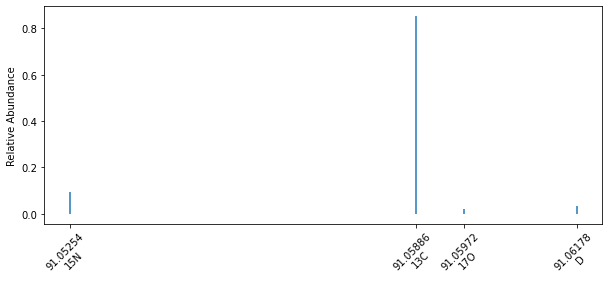

In [4]:
spectrumVis.MNSpectrumVis(df, 'full', predictedMeasurement, 'M1', MNDict, 
              lowAbundanceCutOff = 0, 
              massError = 0, 
              xlim = (), 
              ylim = ())

Once the peaks of interest have been selected and identified, we recommend building a model of a sample/standard comparison to determine whether the molecule, fragments etc. are defined properly (e.g. there are no better ways to define sites, no errors in the input fragments). First, we should do this assuming a measurement which is perfect except that some peaks are not observed. We can define these using the abundance threshold and the forbiddenPeaks tools. For example, in this case, our experiment showed we did not observe the full 17O or D peaks as well as the 44 D peak. 

In [5]:
deltas = [-30,-30,0,0,0,0]
fragSubset = ['full', '44']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltas, fragSubset)

unresolvedDict = {}
calcFF = False
forbiddenPeaks = {'M1':{'full':['17O','D'],'44':['D']}}
UValueList = ['13C']

predictedMeasurement, MNDict, fractionationFactors = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0.0,
                                                   outputPath = str(today) + " TUTORIAL 3 Sample",
                                                               calcFF = calcFF,
                                                               ffstd = 0.05,
                                                   unresolvedDict = unresolvedDict,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   MNMassThreshold = 1,
                                                   molecularAvgMassThreshold = 1)

100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 24194.86it/s]

Delta 18O
0.0
Calculating Isotopologue Concentrations
Compiling Isotopologue Dictionary
Simulating Measurement


We then check the measurement to make sure only the peaks we actually observed appear

In [6]:
predictedMeasurement['M1']

{'full': {'15N': {'Abs. Abundance': 0.0035240895610821757,
   'Rel. Abundance': 0.09577373138104994,
   'Combined Rel. Abundance': 0.09577373138104994,
   'Adj. Rel. Abundance': 0.10105494100931567},
  '13C': {'Abs. Abundance': 0.03134891640858447,
   'Rel. Abundance': 0.8519654926933189,
   'Combined Rel. Abundance': 0.8519654926933189,
   'Adj. Rel. Abundance': 0.8989450589906843}},
 '44': {'Unsub': {'Abs. Abundance': 0.011476686579950324,
   'Rel. Abundance': 0.3119004436751976,
   'Combined Rel. Abundance': 0.3119004436751976,
   'Adj. Rel. Abundance': 0.31968438434406377},
  '15N': {'Abs. Abundance': 0.0035240895610821757,
   'Rel. Abundance': 0.09577373138104994,
   'Combined Rel. Abundance': 0.09577373138104994,
   'Adj. Rel. Abundance': 0.09816390766269176},
  '13C': {'Abs. Abundance': 0.02089927760572298,
   'Rel. Abundance': 0.5679769951288792,
   'Combined Rel. Abundance': 0.5679769951288792,
   'Adj. Rel. Abundance': 0.5821517079932446}}}

If our result is as expected, we then generate a standard with the same conditions

In [7]:
deltas = [-30,-30,0,0,0,0]
fragSubset = ['full', '44']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltas, fragSubset)

unresolvedDict = {}
calcFF = False

predictedMeasurement, MNDict, fractionationFactors = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0.0,
                                                   outputPath = str(today) + " TUTORIAL 3 Standard",
                                                               calcFF = calcFF,
                                                               ffstd = 0.05,
                                                   unresolvedDict = unresolvedDict,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   MNMassThreshold = 1,
                                                   molecularAvgMassThreshold = 1)

100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 25415.75it/s]

Delta 18O
0.0
Calculating Isotopologue Concentrations
Compiling Isotopologue Dictionary
Simulating Measurement


We then attempt to solve this system. We generate a forward model standard--note here the abundance threshold is set to 0 and forbiddenPeaks is empty; the forward model should be a perfect measurement. 

In [8]:
deltas = [-30,-30,0,0,0,0]
fragSubset = ['full','44']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltas, fragSubset)

forbiddenPeaks = {}

predictedMeasurement, MNDictStd, FF = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                      expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0,
                                                     unresolvedDict = {},
                                                    outputFull = False,
                                                    omitMeasurements = forbiddenPeaks,
                                                  MNMassThreshold = 1)

  0%|                                                                                         | 0/1512 [00:00<?, ?it/s]

Delta 18O
0.0
Calculating Isotopologue Concentrations


100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 19527.43it/s]

Compiling Isotopologue Dictionary
Simulating Measurement


Our sample and standard are the same, so our solution should be exact; indeed it will be exact for any sites we actually constrain. However, it may be inexact for sites we do not constrain. This allows us to determine what information is theoretical achievable given the peaks we observed. 

We can get a plot of the underconstrained by setting plotUnconstrained = True

In [1]:
standardJSON = ri.readJSON("2021-08-11 TUTORIAL 3 Standard.json")
processStandard = ri.readComputedData(standardJSON, error = 0, theory = predictedMeasurement)

sampleJSON = ri.readJSON("2021-08-11 Alanine Sample.json")
processSample = ri.readComputedData(sampleJSON, error = 0)
UValuesSmp = ri.readComputedUValues(sampleJSON, error = 0)

isotopologuesDict = fas.isotopologueDataFrame(MNDictStd, df)
pACorrection = ss.percentAbundanceCorrectTheoretical(predictedMeasurement, processSample, massThreshold = 1)

M1Results = ss.M1MonteCarlo(processStandard, processSample, pACorrection, isotopologuesDict,
                            fragmentationDictionary, experimentalPACorrectList = [], 
                            N = 100, GJ = False, debugMatrix = False, pACorrect = True, WCorrect = True,
                           perturbTheoryPAAmt = 0, debugUnderconstrained = True, plotUnconstrained = False)

processedResults = ss.processM1MCResults(M1Results, UValuesSmp, isotopologuesDict, df, GJ = False, 
                                         UMNSub = ['13C'])
ss.updateSiteSpecificDfM1MC(processedResults, df)

NameError: name 'ri' is not defined

Next, we can start to interrogate how different experimental difficulties will affect our results. We can define a sample that differs from the standard. Here, we set calcFF = True, to allow experimental fractionation. And we specify an unresolved Dict, allowing the full 17O peak to contribute to the full 13C peak.

In [11]:
###NEW SAMPLE
deltasSmp = [-40,-20,0,-10,25,40]
fragSubset = ['full', '44']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltasSmp, fragSubset)

unresolvedDict = {}
calcFF = True
forbiddenPeaks = {'M1':{'full':['17O','D'],'44':['D']}}
UValueList = ['13C']
unresolvedDict = {'M1':{'full':{'17O':'13C'}}}

predictedMeasurement, MNDict, fractionationFactors = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0.0,
                                                   outputPath = str(today) + " TUTORIAL 3 Sample",
                                                               calcFF = True,
                                                               ffstd = 0.05,
                                                   unresolvedDict = unresolvedDict,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   MNMassThreshold = 1,
                                                   molecularAvgMassThreshold = 1)

###NEW STANDARD
deltasStd = [-30,-30,0,0,0,0]
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltasStd, fragSubset)

predictedMeasurement, MNDict, FF = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                                 expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0.0,
                                                   outputPath = str(today) + " TUTORIAL 3 Standard",
                                                               calcFF = False,
                                                               ffstd = 0.05,
                                                   fractionationFactors = fractionationFactors,
                                                   unresolvedDict = unresolvedDict,
                                                   outputFull = False,
                                                   omitMeasurements = forbiddenPeaks,
                                                   UValueList = UValueList,
                                                   MNMassThreshold = 1,
                                                   molecularAvgMassThreshold = 1)


  0%|                                                                                         | 0/1512 [00:00<?, ?it/s]

Delta 18O
0.0
Calculating Isotopologue Concentrations
Compiling Isotopologue Dictionary


100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 15999.59it/s]

Simulating Measurement
Delta 18O
0.0
Calculating Isotopologue Concentrations
Compiling Isotopologue Dictionary
Simulating Measurement


Next, we calculate our forward model--here we assume we don't actually know the standard perfectly, introducing some errors. 

In [12]:
#deltas = [-35,-20,0,-7,50,-50]
deltas = [-30,-30,0,0,0,0]
fragSubset = ['full','44']
df, expandedFrags, fragSubgeometryKeys, fragmentationDictionary = alanineTest.initializeAlanine(deltas, fragSubset)

forbiddenPeaks = {}

predictedMeasurement, MNDictStd, FF = alanineTest.simulateMeasurement(df, fragmentationDictionary, 
                                                                      expandedFrags, fragSubgeometryKeys, 
                                                   abundanceThreshold = 0,
                                                     unresolvedDict = {},
                                                    outputFull = False,
                                                    omitMeasurements = forbiddenPeaks,
                                                  MNMassThreshold = 1)

  0%|                                                                                         | 0/1512 [00:00<?, ?it/s]

Delta 18O
0.0
Calculating Isotopologue Concentrations
Compiling Isotopologue Dictionary


100%|███████████████████████████████████████████████████████████████████████████| 1512/1512 [00:00<00:00, 21971.04it/s]

Simulating Measurement


Then we solve--introducing experimental error and a perturbation to the PA Value correction (perturbTheoryPAAmt) both of which also add to the error of our solution. This gives us a reasonable baseline as to how accurate a solution we can expect for our system in a real situation. 

In [13]:
processSample

{'M1': {'full': {'Subs': ['15N', '13C'],
   'Predicted Abundance': [],
   'Observed Abundance': [0.10105494100931567, 0.8989450589906843],
   'Error': [0.0, 0.0]},
  '44': {'Subs': ['Unsub', '15N', '13C'],
   'Predicted Abundance': [],
   'Observed Abundance': [0.31968438434406377,
    0.09816390766269176,
    0.5821517079932446],
   'Error': [0.0, 0.0, 0.0]}}}

In [14]:
processStandard

{'M1': {'full': {'Subs': ['15N', '13C'],
   'Predicted Abundance': [0.09577373138104994, 0.8519654926933189],
   'Observed Abundance': [0.10105494100931567, 0.8989450589906843],
   'Error': [0.0, 0.0],
   'Perturbed': array([0.10105494, 0.89894506]),
   'Correction Factor': array([1.05514257, 1.05514257])},
  '44': {'Subs': ['Unsub', '15N', '13C'],
   'Predicted Abundance': [0.3119004436751976,
    0.09577373138104994,
    0.5679769951288792],
   'Observed Abundance': [0.31968438434406377,
    0.09816390766269176,
    0.5821517079932446],
   'Error': [0.0, 0.0, 0.0],
   'Perturbed': array([0.31968438, 0.09816391, 0.58215171]),
   'Correction Factor': array([1.02495649, 1.02495649, 1.02495649])}}}

In [15]:
standardJSON = ri.readJSON("2021-06-28 TUTORIAL 3 Standard.json")
processStandard = ri.readComputedData(standardJSON, error = 0.001, theory = predictedMeasurement)

sampleJSON = ri.readJSON("2021-06-28 TUTORIAL 3 Sample.json")
processSample = ri.readComputedData(sampleJSON, error = 0.001)
UValuesSmp = ri.readComputedUValues(sampleJSON, error = 0.0001)

isotopologuesDict = fas.isotopologueDataFrame(MNDictStd, df)
pACorrection = ss.percentAbundanceCorrectTheoretical(predictedMeasurement, processSample, massThreshold = 1)

M1Results = ss.M1MonteCarlo(processStandard, processSample, pACorrection, isotopologuesDict,
                            fragmentationDictionary, experimentalPACorrectList = [], 
                            N = 1000, GJ = False, debugMatrix = False, pACorrect = True, WCorrect = True,
                           perturbTheoryPAAmt = 0.001)

processedResults = ss.processM1MCResults(M1Results, UValuesSmp, isotopologuesDict, df, GJ = False, 
                                         UMNSub = ['13C'])
ss.updateSiteSpecificDfM1MC(processedResults, df)

  4%|███▎                                                                           | 42/1000 [00:00<00:04, 203.31it/s]

Solution is underconstrained
processM1MCResults will not work with GJ Solution
After solving null space:
Actually Constrained:
13C Ccarboxyl
13C Calphabeta
15N Namine
D Hretained


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 233.30it/s]


,IDS,Number,deltas,full_01,44_01,PDB etc. Deltas,PDB etc. Deltas Error,Relative Deltas,Relative Deltas Error,M1 Percent Abundance,M1 Percent Abundance Error,UM1,UM1 Error,Calc U Values,Calc U Values Error
Calphabeta,C,2,-30,1,1,-40.445104,1.599369,-10.768148,1.648834,0.564181,0.000718,0.038224,0.00004,0.021565,0.000036
Ccarboxyl,C,1,-30,1,x,-19.109268,3.189024,11.227558,3.287653,0.288364,0.001151,0.038224,0.00004,0.011022,0.000036
Ocarboxyl,O,2,0,1,x,-296.493461,33.135486,-296.493461,33.135486,0.013983,0.000648,0.038224,0.00004,0.000535,0.000025
Namine,N,1,0,1,1,-10.190009,1.559223,-10.190009,1.559223,0.095189,0.000133,0.038224,0.00004,0.003639,0.000006
Hretained,H,6,0,1,1,-6.162912,39.765432,-6.162912,39.765432,0.024299,0.000972,0.038224,0.00004,0.000929,0.000037
Hlost,H,2,0,1,x,715.858592,80.817741,715.858592,80.817741,0.013983,0.000648,0.038224,0.00004,0.000535,0.000025


Because our standard is poorly known, we are most interested in the relative deltas column. We can see how well we did by comparing with the actual values.

In [16]:
relativeDeltas = [op.compareRelDelta(atomID, delta1, delta2) for atomID, delta1, delta2 in zip(df['IDS'], deltasStd, deltasSmp)]

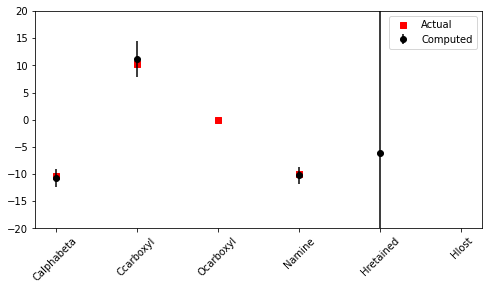

In [17]:
fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(range(len(relativeDeltas)),relativeDeltas, label = 'Actual', marker = 's', color = 'r')
plt.errorbar(range(len(relativeDeltas)),df['Relative Deltas'],df['Relative Deltas Error'], fmt = 'o',c='k',
            label = 'Computed')
plt.legend()
plt.ylim(-20,20)
ax.set_xticks(range(len(relativeDeltas)))
ax.set_xticklabels(df.index, rotation = 45);

We see we accurately recover the values for Calphabeta, Ccarboxyl, and Namine (and Hretained, but at poor precision)

We leave this tutorial with one further demonstration. A useful tool for visualizing correlations is the "corner plot", which displays correlations between pairs of variables. The corner module is good for doing this out of the box; the seaborn library has many additional tools that can achieve something similar. Here, we plot historgrams of both carbons and the nitrogen sites (along the diagonal) and 2D correlation plots (in the lower triangle). We see a clear correlation between the carbon sites (expected, as they must sum to the same value each iteration). 

Results seem to plot best for N >= 1000. 

With that, the tutorial is finished! There are more features to learn and use, and we encourage interested users to work through the tests to interrogate these problems. We welcome suggestions for improvements to this code, and especially to our correction schemes. There is one additional module--tutorial 4--which shows how to import real experimental results from a .json file. With that, users should be able to solve for isotopic information in their own systems of interest. 

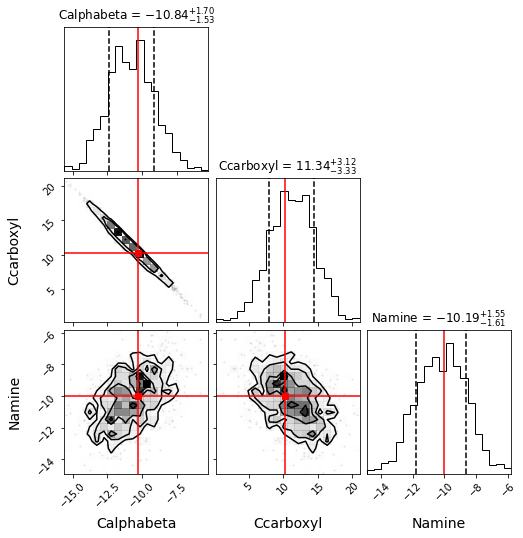

In [18]:
import corner

x = processedResults['Relative Deltas']
z = np.array(x)

y = z[:,np.r_[0:2,3]]
truths = np.array(relativeDeltas)[np.r_[0:2,3]]
ndim = 3
figure = corner.corner(y, labels=["Calphabeta", "Ccarboxyl", "Namine"],
                       quantiles=[0.16, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12},
                       label_kwargs = {'fontsize':14},
                      truths = truths, truth_color = 'r')